In [1]:
import dtlpy as dl
import pandas as pd
from tqdm import tqdm
import numpy as np
from datetime import date, timedelta, datetime, timezone
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
import os

if dl.token_expired():
    dl.login()


c:\Users\milton\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\milton\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\milton\anaconda3\lib\site-packages\seaborn\rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\milton\anaconda3\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


-----------------------------

Analisis final

In [2]:
def get_general_function_report(project_id, dataset_golden_id, dataset_task_id):
    project = dl.projects.get(project_id=project_id)
    dataset_golden = project.datasets.get(dataset_id=f'{dataset_golden_id}')
    dataset_task = project.datasets.get(dataset_id=f'{dataset_task_id}')
    return [dataset_golden,dataset_task]


In [3]:
def get_duplicates_items(dataset_golden):
    
    list_ids = []
    for folder in dataset_golden.items.list():
        for item in folder:
            item_id = item.metadata['user']['ID']
            list_ids.append(item_id)

    duplicates = [value for value in set(list_ids) if list_ids.count(value) > 1]
    return duplicates

In [4]:
def get_general_report_v_2(dataset_ground_truth, dataset_task, duplicates):

    def get_item_link(item_id):

        project = dl.projects.get(project_id='0c8c900e-468c-4c77-aaab-1871333f772b')
        dataset = project.datasets.get(dataset_id='65941df20d5a6843e79c93ed')

        filters = dl.Filters()
        filters.resource = dl.FiltersResource.ITEM
        filters.add(field='metadata.user.ID', values=item_id)
        itemid = dataset.items.list(filters=filters)[0][0].id
        return fr'https://console.dataloop.ai/projects/{project.id}/datasets/{dataset.id}/items/{itemid}'


    path = r'G:\My Drive\Taggers Qualification - Reports'
    owner = dataset_task.tasks.list()[0].task_owner
    category = dataset_ground_truth.name.split(" - ")[1]
    new_path = os.path.join(path,owner,category)


    dict_report = []

    task = dataset_task.tasks.list()[0]
    assigments_ids = [assig.id for assig in task.assignments.list()]

    for folder in dataset_task.items.list():
        for item in folder:
            item_id = item.metadata['user']['ID']
            
            # if item_id not in duplicates:
            if item_id not in duplicates:

                filters = dl.Filters()
                filters.resource = dl.FiltersResource.ITEM
                filters.add(field='metadata.user.ID', values=item_id)

                item_in_folder = dataset_ground_truth.items.list(filters=filters)[0]
                # print (item_in_folder)
                item_gt = item_in_folder[0]

                dict_entry = {
                    'Item_id': item_id,
                    'Link': get_item_link(item_id),
                    'Label_ground_truth': item_gt.metadata['user']['Subcategory_name'],
                }


                assign_report = {}
                filters_assign = dl.Filters(use_defaults=False)
                filters_assign.add(field='metadata.user.ID', values=item_id)

                filters_assign.add(field='metadata.system.refs.id', values=assigments_ids, operator=dl.FiltersOperations.IN)

                for folder in task.get_items(filters=filters_assign):
                    for item_asg in folder:
                        try:
                            label_annot = item_asg.annotations.list()[0].label.rstrip(',').split(' - ')[1]
                        except IndexError:
                            label_annot = 'No label' #To check 
                        
                        for accion in item_asg.metadata['system']['refs']:
                            if accion['type'] == 'assignment':
                                assignment_id = accion['id']
                        
                        annotator = dataset_task.assignments.get(assignment_id=assignment_id).annotator
                        
                        assign_report[annotator] = label_annot

                dict_entry.update(assign_report)
            
                dict_report.append(dict_entry)


    dict_report_df = pd.DataFrame(dict_report)


    file_to_created = os.path.join(new_path,
        dataset_task.name)
    
    # Create the folder if it doesn't exist
    os.makedirs(file_to_created, exist_ok=True)

    file_path = os.path.join(new_path,
        dataset_task.name,
        f'General_report_{dataset_task.name}.xlsx'
    )

    dict_report_df.to_excel(file_path, index=False, sheet_name='General_report')

    print ('General report generated')
    return dict_report_df

In [5]:
def get_general_report_v_3(dataset_ground_truth, dataset_task, duplicates):

    def get_item_link(item_id):

        project = dl.projects.get(project_id='0c8c900e-468c-4c77-aaab-1871333f772b')
        dataset = project.datasets.get(dataset_id='65941df20d5a6843e79c93ed')

        filters = dl.Filters()
        filters.resource = dl.FiltersResource.ITEM
        filters.add(field='metadata.user.ID', values=item_id)
        itemid = dataset.items.list(filters=filters)[0][0].id
        return fr'https://console.dataloop.ai/projects/{project.id}/datasets/{dataset.id}/items/{itemid}'


    path = r'G:\My Drive\Taggers Qualification - Reports'
    owner = dataset_task.tasks.list()[0].task_owner
    category = dataset_ground_truth.name.split(" - ")[1]
    new_path = os.path.join(path,owner,category)


    dict_report = []

    task = dataset_task.tasks.list()[0]
    assigments_ids = [assig.id for assig in task.assignments.list()]

    for folder in dataset_task.items.list():
        for item in folder:
            item_id = item.metadata['user']['ID']
            
            # if item_id not in duplicates:
            if item_id not in duplicates:

                filters = dl.Filters()
                filters.resource = dl.FiltersResource.ITEM
                filters.add(field='metadata.user.ID', values=item_id)

                item_in_folder = dataset_ground_truth.items.list(filters=filters)[0]
                # print (item_in_folder)
                item_gt = item_in_folder[0]

                dict_entry = {
                'Item_id': item_id,
                'Link': get_item_link(item_id),
                'Team': dataset_task.name.split('_')[0],
                'Date': dataset_task.name.split('_')[2],
                'Label_ground_truth': item_gt.metadata['user']['Subcategory_name']}


                assign_report = {}
                filters_assign = dl.Filters(use_defaults=False)
                filters_assign.add(field='metadata.user.ID', values=item_id)

                filters_assign.add(field='metadata.system.refs.id', values=assigments_ids, operator=dl.FiltersOperations.IN)

                for folder in task.get_items(filters=filters_assign):
                    for item_asg in folder:
                        annotations_list = item_asg.annotations.list()
                        label_annot = 'No label'
                        if annotations_list:
                            label_annot = annotations_list[0].label.split(' - ')[1] if ' - ' in annotations_list[0].label else annotations_list[0].label

                        for accion in item_asg.metadata['system']['refs']:
                            if accion['type'] == 'assignment':
                                assignment_id = accion['id']
                        
                        annotator = dataset_task.assignments.get(assignment_id=assignment_id).annotator
                        
                        assign_report[annotator] = label_annot

                dict_entry.update(assign_report)
            
                dict_report.append(dict_entry)


    dict_report_df = pd.DataFrame(dict_report)

    #add New columns in general report 1

    # Get the list of annotator columns
    annotator_columns = dict_report_df.columns[5:]

    # Counting the number of annotators
    num_annotators = len(annotator_columns)

    # Counting the number of annotators agreeing with Label_ground_truth
    dict_report_df['num_matching_annotators'] = dict_report_df.apply(lambda row: sum(row[annotator_columns] == row['Label_ground_truth']), axis=1)

    # Calculating the number of annotators not agreeing
    dict_report_df['num_non_matching_annotators'] = num_annotators - dict_report_df['num_matching_annotators']


    file_to_created = os.path.join(new_path,
        dataset_task.name)
    
    # Create the folder if it doesn't exist
    os.makedirs(file_to_created, exist_ok=True)

    file_path = os.path.join(new_path,
        dataset_task.name,
        f'General_report_{dataset_task.name}.xlsx'
    )

    dict_report_df.to_excel(file_path, index=False, sheet_name='General_report')

    print ('General report generated')
    return dict_report_df

In [6]:
def generate_new_update_report(dataset_ground_truth,dataset_task, dict_report_df):

    path = r'G:\My Drive\Taggers Qualification - Reports'
    owner = dataset_task.tasks.list()[0].task_owner
    category = dataset_ground_truth.name.split(" - ")[1]
    new_path = os.path.join(path,owner,category)



    refactored_df = pd.melt(dict_report_df.iloc[:, :-2], id_vars=['Item_id', 'Link', 'Team', 'Date'], var_name='Annotator', value_name='Label')
    refactored_df = refactored_df.sort_values(by=['Item_id','Annotator'])
    refactored_df


    # Specify the path to your existing Excel file
    existing_excel_file = os.path.join(new_path,
        dataset_task.name,
        f'General_report_{dataset_task.name}.xlsx'
    )

    # Load the existing Excel file
    with pd.ExcelWriter(existing_excel_file, engine='openpyxl', mode='a') as writer:
        # Display the result
        
        refactored_df.to_excel(writer, index=False, sheet_name='general_report_2')
        print('general_report_2 generated')

In [7]:
def general_confusion_matrix (dict_report_df,dataset_task,dataset_ground_truth):

    path = r'G:\My Drive\Taggers Qualification - Reports'
    owner = dataset_task.tasks.list()[0].task_owner
    category = dataset_ground_truth.name.split(" - ")[1]
    new_path = os.path.join(path,owner,category)

    # Assuming 'data' is your dataframe
    # Replace 'Label_ground_truth' and the email columns with the actual column names in your dataframe
    labels = dict_report_df['Label_ground_truth'].unique()
    columns_to_check = dict_report_df.columns[5:-2] ####[5:-2]

    conf_matrix_sum = pd.DataFrame(index=labels, columns=labels, data=0)

    for col in columns_to_check:
        # Create a confusion matrix for each email column
        conf_matrix = confusion_matrix(dict_report_df['Label_ground_truth'], dict_report_df[col], labels=labels)
        
        # Update the summary confusion matrix
        conf_matrix_sum += conf_matrix

    # Plot the unique confusion matrix with colors
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_sum, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Unique Confusion Matrix')
    
    # Save the figure with axes and labels

    file_path = os.path.join(new_path,
        dataset_task.name,
        'general_confusion_matrix.png'
    )

    plt.savefig(file_path,bbox_inches='tight',facecolor='white')

    return plt.show()


In [8]:
def get_precision_recall(df, tested, dataset_task, dataset_ground_truth):
    
    path = r'G:\My Drive\Taggers Qualification - Reports'
    owner = dataset_task.tasks.list()[0].task_owner
    category = dataset_ground_truth.name.split(" - ")[1]
    new_path = os.path.join(path,owner,category)

    # Assuming you have true labels and predicted labels
    true_labels = df['Label_ground_truth']
    predicted_labels = df[f'{tested}']

    # Get unique labels
    unique_labels = df['Label_ground_truth'].unique()

    # Calculate precision and recall for each label
    precision_scores = {}
    recall_scores = {}
    label_counts = {}

    for label in unique_labels:
        true_label_binary = (true_labels == label).astype(int)
        predicted_label_binary = (predicted_labels == label).astype(int)

        # Add zero_division=0 to handle the case when precision is undefined
        precision = precision_score(true_label_binary, predicted_label_binary, zero_division=0)
        recall = recall_score(true_label_binary, predicted_label_binary)

        precision_scores[label] = precision
        recall_scores[label] = recall
        label_counts[label] = true_label_binary.sum()


    # Print precision and recall for each label
    label_precision = []
    for label in unique_labels:
        label_precision.append({"Label": f'{label}',
                                "Count": label_counts[label],
                                "Precision": f'{precision_scores[label]:.2f}',
                                "Recall": f'{recall_scores[label]:.2f}'})

    # Save the results to a CSV file
    file_path = os.path.join(new_path,
        dataset_task.name,
        f'{tested}.xlsx'
    )

    pd.DataFrame(label_precision).to_excel(file_path, index=False, sheet_name='precision_recall')
    print ('Label precision generated')

# Example usage
# Replace df and list_tested with your actual DataFrame and list of tested labels
# get_precision_recall(df, list_tested)


In [9]:
def error_tables(df, tested, dataset_task,dataset_ground_truth):

    path = r'G:\My Drive\Taggers Qualification - Reports'
    owner = dataset_task.tasks.list()[0].task_owner
    category = dataset_ground_truth.name.split(" - ")[1]
    new_path = os.path.join(path,owner,category)

    ## Filter rows where Label_ground_truth is different from yair.wolff@taranis.com
    # filtered_df = df[df['Label_ground_truth'] != df[f'{tested}']]   
    label_counts = df['Label_ground_truth'].value_counts()

    # Calculate counts and percentage
    result_df = df.groupby(['Label_ground_truth', f'{tested}']).agg(
        # Change column name 'Errors' to '# of items'
        # Change column name 'Percentage of wrong labels' to 'Percentage'
        **{
            '# of items': ('Item_id', 'count'),
            'Image_Ids': ('Item_id', lambda x: x.tolist())
        }
    ).reset_index()

    # Calculate Percentage, handling division by zero
    result_df['Percentage'] = result_df.apply(
        lambda row: f"{(row['# of items'] / label_counts.get(row['Label_ground_truth'], 1) * 100):.2f}%",
        axis=1
    )

    # Renaming columns
    result_df = result_df[['Label_ground_truth', f'{tested}', '# of items', 'Percentage', 'Image_Ids']]

    # Specify the path to your existing Excel file
    existing_excel_file = os.path.join(new_path,
        dataset_task.name,
        f'{tested}.xlsx'
    )

    # Load the existing Excel file
    with pd.ExcelWriter(existing_excel_file, engine='openpyxl', mode='a') as writer:
        # Display the result
        
        result_df.to_excel(writer, index=False, sheet_name='tester_report')
        print('Tester report generated')

# Example usage
# Replace 'tested_column' with the actual column name you want to test
# error_tables('tested_column')


Iterate Pages: 100%|██████████| 1/1 [17:23<00:00, 1043.74s/it]
General report generated
general_report_2 generated


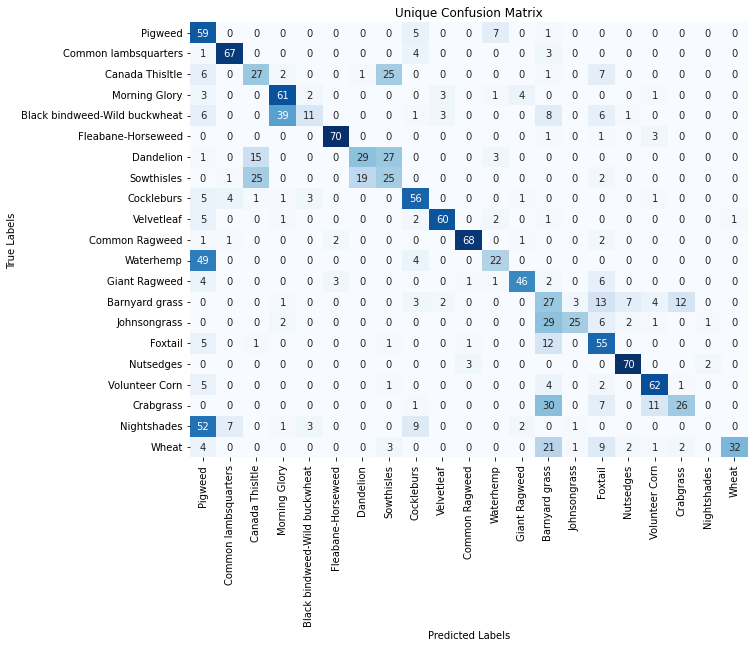

Label precision generated
Tester report generated
Label precision generated
Tester report generated
Label precision generated
Tester report generated


In [10]:
project_id = '0c8c900e-468c-4c77-aaab-1871333f772b'
dataset_golden_id = '65941df20d5a6843e79c93ed'
dataset_task_id = '66167246bb629a14ae0452ec'

results = get_general_function_report(project_id, dataset_golden_id, dataset_task_id)

dataset_golden = results[0]
dataset_task = results[1]

duplicates_list = get_duplicates_items(dataset_golden)
dict_report_df = get_general_report_v_3(dataset_golden, dataset_task, duplicates_list)
generate_new_update_report(dataset_golden, dataset_task, dict_report_df)
general_confusion_matrix(dict_report_df, dataset_task,dataset_golden)

list_tested = [col for col in dict_report_df.columns[5:-2]] ###[5:-2]
for tested in list_tested:
    get_precision_recall(dict_report_df, tested,dataset_task,dataset_golden)
    error_tables(dict_report_df,tested,dataset_task,dataset_golden)